In [1]:
from BayesianNetwork import *
from ExactInference import *
from ApproximateInference import *
from datetime import datetime
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# global varaibles

T = True
F = False
# Bayes Nets
# AIMA-ALARM example
BN_alarm = BayesNet([
    ('Burglary', [], {(): 0.001}),
    ('Earthquake', [], {(): 0.002}),
    ('Alarm', ['Burglary', 'Earthquake'], {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001}),
    ('JohnCalls', ['Alarm'], {(T,): 0.90, (F,): 0.05}),
    ('MaryCalls', ['Alarm'], {(T,): 0.70, (F,): 0.01})
])
# our Bayes Net
BN_horse = BayesNet([
    ('SunnyDay', [], {(): 0.7}),
    ('RadioOn', [], {(): 0.6}),
    ('HorseAWins', ['SunnyDay'], {(T,): 0.6, (F,): 0.3}),
    ('HorseBWins', ['SunnyDay'], {(T,): 0.8, (F,): 0.3}),
    ('JohnCalls', ['HorseAWins', 'HorseBWins'], {(T, T): 0.9, (T, F): 0.8, (F, T): 0.7, (F, F): 0.4}),
    ('MikeCalls', ['HorseAWins', 'HorseBWins'], {(T, T): 0.96, (T, F): 0.7, (F, T): 0.9, (F, F): 0.2}),
    ('AlianKnows', ['JohnCalls'], {(T,): 0.9, (F,): 0.2}),
    ('LilyKnows', ['MikeCalls', 'RadioOn'], {(T, T): 0.95, (T, F): 0.8, (F, T): 0.5, (F, F): 0.1}),
])
# queries
q_alarm = {
    'causal': {'X': 'JohnCalls', 'e': {'Earthquake': F}},
    'diagnostic': {'X': 'Burglary', 'e': {'JohnCalls': T}},
    'sanity': {'X': 'MaryCalls', 'e': {'Alarm': T}}
}
q_horse = {
    'causal': {'X': 'AlianKnows', 'e': {'SunnyDay': T}},
    'diagnostic': {'X': 'HorseBWins', 'e': {'LilyKnows': T}},
    'sanity': {'X': 'LilyKnows', 'e': {'HorseBWins': F, 'HorseAWins': F}}
}

In [3]:
def generate_syntax(X, e, bool=True):
    """generate the syntax of a query, e.q., P(SunnyDay=True|AlianKnows=True,LilyKnows=True)"""
    res = "P("
    res += f"{X}=True|" if bool else f"{X}=False|"
    for k,v in e.items():
        res += f"{k}={v},"
    res = res[:-1] + ")"
    return res

In [4]:
def print_res(method, query, p):
    """ print the result of a query"""
    print(f"{method}:")
    print(generate_syntax(query['X'], query['e']) + f" = {round(p[T], 4)}")
    print(generate_syntax(query['X'], query['e'], F)+ f" = {round(p[F], 4)}")
    print("------------------")

## Exact Inference

In [5]:
def exact_inference(BN, query):
    """exact inference"""
    # causal reasoning
    causal_q = query['causal']
    p = enumeration_ask(causal_q['X'], causal_q['e'], BN)
    print_res("causal reasoning", causal_q, p)

    # diagnostic reasoning
    diagnostic_q = query['diagnostic']
    p = enumeration_ask(diagnostic_q['X'], diagnostic_q ['e'], BN)
    print_res("diagnostic reasoning", diagnostic_q, p)
    
    # sanity check
    sanity_q = query['sanity']
    p = enumeration_ask(sanity_q['X'], sanity_q['e'], BN)
    print_res("sanity check", sanity_q, p)
   

In [6]:
exact_inference(BN_alarm, q_alarm)
exact_inference(BN_horse, q_horse)

causal reasoning:
P(JohnCalls=True|Earthquake=False) = 0.0516
P(JohnCalls=False|Earthquake=False) = 0.9484
------------------
diagnostic reasoning:
P(Burglary=True|JohnCalls=True) = 0.0163
P(Burglary=False|JohnCalls=True) = 0.9837
------------------
sanity check:
P(MaryCalls=True|Alarm=True) = 0.7
P(MaryCalls=False|Alarm=True) = 0.3
------------------
causal reasoning:
P(AlianKnows=True|SunnyDay=True) = 0.7488
P(AlianKnows=False|SunnyDay=True) = 0.2512
------------------
diagnostic reasoning:
P(HorseBWins=True|LilyKnows=True) = 0.737
P(HorseBWins=False|LilyKnows=True) = 0.263
------------------
sanity check:
P(LilyKnows=True|HorseBWins=False,HorseAWins=False) = 0.45
P(LilyKnows=False|HorseBWins=False,HorseAWins=False) = 0.55
------------------


## Approximate Inference

In [7]:
def appro_inference(BN, query, rej_sample_size=10000, gibbs_sample_size=300):  
    """ approximate inference """
    X = query['X']
    e = query['e'] 
    p_enum = enumeration_ask(X, e, BN)
    sample = Sample()    
    p_rej = sample.rejection_sampling(X, e, BN, rej_sample_size)     
    p_gibbs = sample.gibbs_sampling(X, e, BN, gibbs_sample_size)
    print_res("enumeration", query, p_enum)
    print_res("rejection sampling", query, p_rej)
    print_res("gribbs sampling", query, p_gibbs)    

In [8]:
appro_inference(BN_alarm, q_alarm['causal'])
appro_inference(BN_alarm, q_alarm['diagnostic'])
appro_inference(BN_alarm, q_alarm['sanity'])
appro_inference(BN_horse, q_horse['causal'])
appro_inference(BN_horse, q_horse['diagnostic'])
appro_inference(BN_horse, q_horse['sanity'])

enumeration:
P(JohnCalls=True|Earthquake=False) = 0.0516
P(JohnCalls=False|Earthquake=False) = 0.9484
------------------
rejection sampling:
P(JohnCalls=True|Earthquake=False) = 0.0487
P(JohnCalls=False|Earthquake=False) = 0.9513
------------------
gribbs sampling:
P(JohnCalls=True|Earthquake=False) = 0.0317
P(JohnCalls=False|Earthquake=False) = 0.9683
------------------
enumeration:
P(Burglary=True|JohnCalls=True) = 0.0163
P(Burglary=False|JohnCalls=True) = 0.9837
------------------
rejection sampling:
P(Burglary=True|JohnCalls=True) = 0.0129
P(Burglary=False|JohnCalls=True) = 0.9871
------------------
gribbs sampling:
P(Burglary=True|JohnCalls=True) = 0.03
P(Burglary=False|JohnCalls=True) = 0.97
------------------
enumeration:
P(MaryCalls=True|Alarm=True) = 0.7
P(MaryCalls=False|Alarm=True) = 0.3
------------------
rejection sampling:
P(MaryCalls=True|Alarm=True) = 0.8148
P(MaryCalls=False|Alarm=True) = 0.1852
------------------
gribbs sampling:
P(MaryCalls=True|Alarm=True) = 0.7258


### Convergence test
- How could you define stability?
    - abs(last_p-now_p)/last_p < threshold
- How many samples are needed for rejection sampling to become stable?
- How many samples are needed for Gibbs sampling to become stable?
- Do these values depend on the structure of the network or the query itself?
- Is one algorithm “better” than the other?

In [9]:
def visual(rec_rej, rec_gib, exact_v, title, N_rej, N_gib, x="number of samples", y="estimate by sampling"):
    """ plot function including exact and approximate inference """
    plt.plot(rec_rej[0], rec_rej[1], 'r-', alpha=0.6, label='rejection sampling')
    plt.plot(rec_gib[0], rec_gib[1], 'b-', alpha=0.6, label='gibbs sampling')  
    plt.xlim([10, max(N_rej, N_gib)]) 
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)        
    plt.axhline(y=exact_v, color='g', alpha=0.2, linestyle='dashed')
    plt.legend()
    plt.show()

In [10]:
# plot the result without convergence test
# sanity_q = q_horse['sanity']
# X = sanity_q['X']
# e = sanity_q['e']

# p = enumeration_ask(X, e, BN_horse)
# conv = {"start_N": 10, "max_N": 10000, "interval": 100, "threshold": 0.01}
# sample = Sample()
# rec_rej = sample.samples(X, e, BN_horse, conv, "rejection")
# rec_gibbs = sample.samples(X, e, BN_horse, conv, "gibbs")
# title = generate_syntax(X, e)
# visual(rec_rej, rec_gibbs, p[T], title, conv)

In [11]:
def test_conv(query, BN, rej_conv, gibbs_conv):
    """ convergence test """
    X = query['X']
    e = query['e']       

    sample = Sample()
    start_time1 = datetime.now()
    rec_rej, N_rej, res_rej  = sample.converge_sampling(X, e, BN, rej_conv, "rejection")
    end_time1 = datetime.now()
    start_time2 = datetime.now()
    rec_gib, N_gib, res_gib = sample.converge_sampling(X, e, BN, gibbs_conv, "gibbs")
    end_time2 = datetime.now()     
    exact_v = enumeration_ask(X, e, BN)[T] 
    
    print(f"rejection sampling {res_rej}")
    print(f"total running time is {(end_time1 - start_time1).total_seconds()*1000} ms")
    print(f"gibbs sampling {res_gib}") 
    print(f"total running time is {(end_time2 - start_time2).total_seconds()*1000} ms")    

    title = generate_syntax(X, e)
    visual(rec_rej, rec_gib, exact_v, title, N_rej, N_gib)

In [19]:
# convergence arguments
rej_conv = {"start_N": 10, "max_N": 10000, "interval": 100, "threshold": 0.01}
gibbs_conv = {"start_N": 10, "max_N": 10000, "interval": 100, "threshold": 0.01}

rejection sampling coverges at N = 810
total running time is 53.177 ms
gibbs sampling coverges at N = 910
total running time is 266.54699999999997 ms


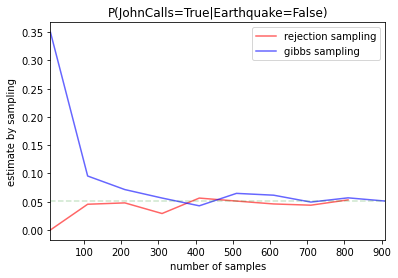

rejection sampling coverges at N = 710
total running time is 42.936 ms
gibbs sampling coverges at N = 1110
total running time is 414.09200000000004 ms


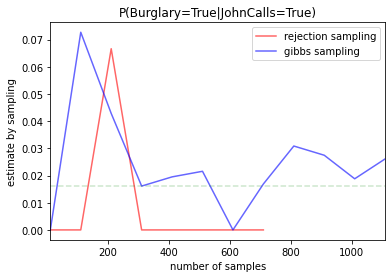

rejection sampling doesn't coverges at max_N = 10000
total running time is 4257.2210000000005 ms
gibbs sampling coverges at N = 1010
total running time is 168.513 ms


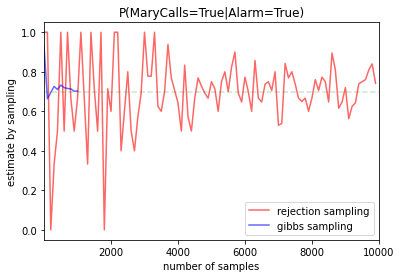

In [20]:
## %%timeit -r5 -n5
# AIAM-ALARM
test_conv(q_alarm['causal'], BN_alarm, rej_conv, gibbs_conv)
test_conv(q_alarm['diagnostic'], BN_alarm, rej_conv, gibbs_conv)
test_conv(q_alarm['sanity'], BN_alarm, rej_conv, gibbs_conv)

rejection sampling coverges at N = 1810
total running time is 349.326 ms
gibbs sampling coverges at N = 3110
total running time is 3550.316 ms


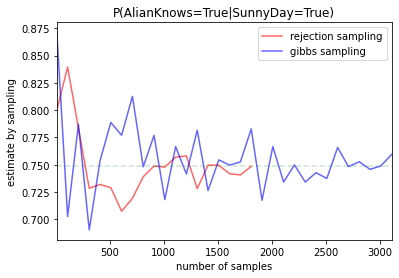

rejection sampling coverges at N = 1110
total running time is 140.15 ms
gibbs sampling coverges at N = 2510
total running time is 3008.978 ms


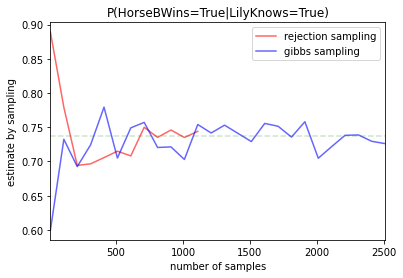

rejection sampling coverges at N = 5310
total running time is 1950.2679999999998 ms
gibbs sampling coverges at N = 3510
total running time is 4449.511 ms


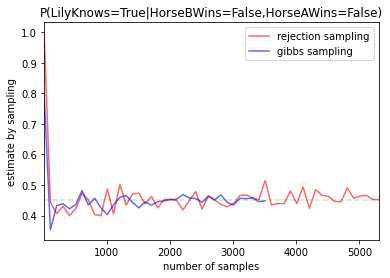

In [14]:
# our example
rej_conv = {"start_N": 10, "max_N": 10000, "interval": 100, "threshold": 0.01}
gibbs_conv = {"start_N": 10, "max_N": 10000, "interval": 100, "threshold": 0.01}
test_conv(q_horse['causal'], BN_horse, rej_conv, gibbs_conv)
test_conv(q_horse['diagnostic'], BN_horse, rej_conv, gibbs_conv)
test_conv(q_horse['sanity'], BN_horse, rej_conv, gibbs_conv)

### Accuracy test

In [15]:
def test_acc(query, BN, rej_conv, gibbs_conv):
    """ accuracy test """
    X = query['X']
    e = query['e']
    
    exact_v = enumeration_ask(X, e, BN)[T]
    sample = Sample()
    rec_rej, N_rej, res_rej  = sample.accuracy_sampling(X, e, BN, rej_conv, "rejection")
    rec_gib, N_gib, res_gib = sample.accuracy_sampling(X, e, BN, gibbs_conv, "gibbs")  
    print(f"rejection sampling {res_rej}")
    print(f"gibbs sampling {res_gib}")   
    
    title = generate_syntax(X,e)
    visual(rec_rej, rec_gib, 0, title, N_rej, N_gib, "number of samples","relative error") # accuracy

rejection sampling achives zero relative error at N = 13110
gibbs sampling achives zero relative error at N = 7910


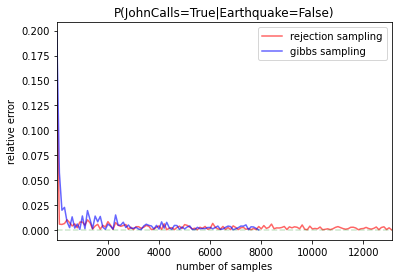

rejection sampling achives zero relative error at N = 16810
gibbs sampling achives zero relative error at N = 5010


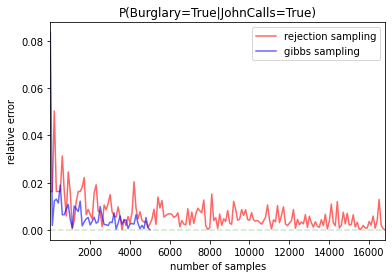

rejection sampling achives zero relative error at N = 4210
gibbs sampling achives zero relative error at N = 310


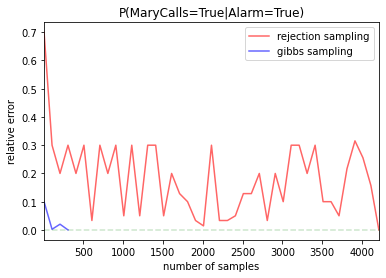

In [16]:
# AIMA-ALARM
rej_conv = {"start_N": 10, "interval": 100, "threshold": 0.0001}
gibbs_conv = {"start_N": 10, "interval": 100, "threshold": 0.0001}
test_acc(q_alarm['causal'], BN_alarm, rej_conv, gibbs_conv)
test_acc(q_alarm['diagnostic'], BN_alarm, rej_conv, gibbs_conv)
test_acc(q_alarm['sanity'], BN_alarm, rej_conv, gibbs_conv)

rejection sampling achives zero relative error at N = 27310
gibbs sampling achives zero relative error at N = 22810


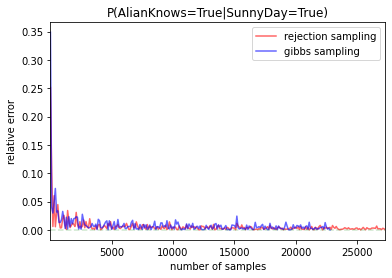

rejection sampling achives zero relative error at N = 11610
gibbs sampling achives zero relative error at N = 2510


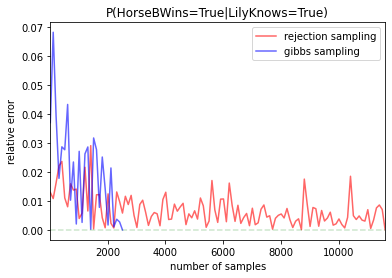

rejection sampling achives zero relative error at N = 6210
gibbs sampling achives zero relative error at N = 6810


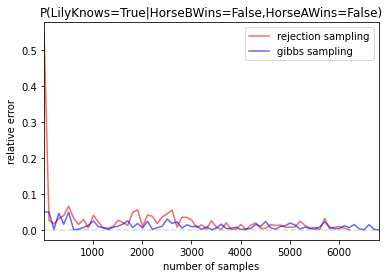

In [21]:
# Our example
rej_conv = {"start_N": 10, "interval": 100, "threshold": 0.001}
gibbs_conv = {"start_N": 10, "interval": 100, "threshold": 0.001}
test_acc(q_horse['causal'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['diagnostic'], BN_horse, rej_conv, gibbs_conv)
test_acc(q_horse['sanity'], BN_horse, rej_conv, gibbs_conv)